# Modelo Aditivo Generalizado (GAM) en el Problema de Viviendas de Boston

Este notebook ajusta un **GAM** para predecir **MEDV** (valor mediano de la vivienda) a partir de dos predictores:
- **LSTAT** — % de población de estatus socioeconómico bajo
- **RM** — número promedio de habitaciones por vivienda

Utilizamos `pygam` para el modelo y lo comparamos con una regresión lineal simple.

> ⚠️ **Disponibilidad del dataset**: El dataset original de Boston está deprecado/eliminado de algunos cargadores.  
> El código a continuación prueba varias opciones. Si ninguna está disponible en tu entorno, generará un pequeño dataset **sintético similar al de Boston** para que puedas ejecutar el flujo de trabajo.

In [4]:
# Si pygam no está disponible, mostrar un mensaje útil
try:
    from pygam import LinearGAM, s
except ImportError as e:
    raise ImportError(
        "pygam no está instalado. Instalar con:\n"
        "  pip install pygam\n"
        "Luego ejecuta esta celda nuevamente."
    ) from e

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

In [5]:
df = pd.read_csv('../data/BostonHousing.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## División entrenamiento/prueba y ajuste de un GAM: `MEDV ~ s(LSTAT) + s(RM)`

In [6]:
X = df[['LSTAT','RM']].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Ajustar un GAM con términos suaves para cada característica; gridsearch ajusta la suavidad (lambda)
gam = LinearGAM(s(0) + s(1)).gridsearch(X_train, y_train)

print("Parámetros de suavizado seleccionados (lambdas):", gam.lam)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


AttributeError: 'csr_matrix' object has no attribute 'A'

## Evaluación

In [6]:
y_pred = gam.predict(X_test)
print("GAM — R^2 de prueba:", round(r2_score(y_test, y_pred), 3))
print("GAM — MAE de prueba:", round(mean_absolute_error(y_test, y_pred), 3))

GAM — Test R^2: 0.734
GAM — Test MAE: 2.884


## Dependencia parcial (funciones suaves)

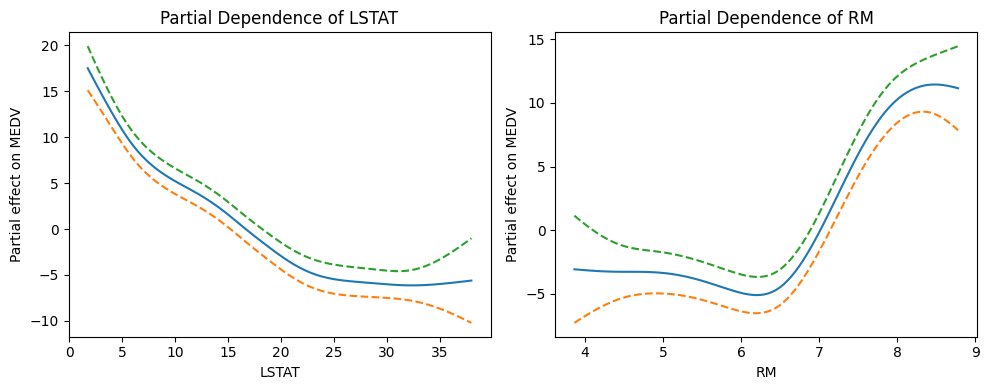

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for i, ax in enumerate(axes):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], linestyle='--')
    ax.set_xlabel(['LSTAT','RM'][i])
    ax.set_ylabel('Efecto parcial en MEDV')
    ax.set_title(f'Dependencia Parcial de {["LSTAT","RM"][i]}')
plt.tight_layout()
plt.show()

## Comparativa con la regresión lineal

In [11]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print("Regresión Lineal — R^2 de prueba:", round(r2_score(y_test, lr_pred), 3))
print("Regresión Lineal — MAE de prueba:", round(mean_absolute_error(y_test, lr_pred), 3))

Linear Regression — Test R^2: 0.578
Linear Regression — Test MAE: 3.957


### Notas para estudiantes
- La función suave para **LSTAT** a menudo muestra una **disminución no lineal** en `MEDV` a medida que `LSTAT` aumenta.
- La función suave para **RM** típicamente muestra un **aumento no lineal** con posible saturación.
- GAM mantiene la **interpretabilidad aditiva** (puedes discutir el efecto de cada característica por separado) mientras captura la no linealidad.